\# Example: Timeseries Battery Data

Let's describe a csv file containing some timeseries battery data and then anaylze it using the ontology!

This example covers a few topics:  

- How to describe tabular data using ontology terms and JSON-LD  
- How machines convert JSON-LD into triples  
- How to process tabular data using its ontology metadata **[Advanced]**  

A live version of this notebook is available on Google Colab [here](https://colab.research.google.com/drive/1i-z6m6MEtQw_MG0Ypn37i0jfySYwize3?usp=sharing)


In [64]:
# Install and import dependencies
!pip install jsonschema rdflib requests matplotlib > /dev/null

import json
import rdflib
import requests
import sys
import pandas as pd
import matplotlib.pyplot as plt

## Describe the csv file using ontology terms in JSON-LD format
The JSON-LD data that we will use is:

In [65]:
metadata = {
            "@context": "https://raw.githubusercontent.com/emmo-repo/domain-battery/master/context.json",
            "@type": "MeasurementResult",
            "csvw:url": "https://raw.githubusercontent.com/BIG-MAP/BattINFO/master/sphinx/assets/data/discharge_timeseries.csv",
            "dc:title": "Synthetic Discharge Curve Demo",
            "dcat:keyword": ["battery", "li-ion", "discharge"],
            "dc:license": {"@id": "http://opendefinition.org/licenses/cc-by/"},
            "dc:modified": {"@value": "2024-01-10", "@type": "xsd:date"},
            "csvw:tableSchema": {
                "csvw:columns": [{
                  "csvw:name": "time",
                  "csvw:titles": "Time / s",
                  "csvw:propertyUrl": {
                    "@type": "Time"
                  },
                  "hasMeasurementUnit": {
                    "@type": "Second"
                  },
                  "csvw:datatype": "number",
                  "csvw:required": "true"
                }, {
                  "csvw:name": "voltage",
                  "csvw:titles": "Voltage / V",
                  "csvw:propertyUrl": {
                    "@type": "CellVoltage"
                  },
                  "hasMeasurementUnit": {
                    "@type": "Volt"
                  },
                  "csvw:datatype": "number"
                }, {
                  "csvw:name": "current",
                  "csvw:titles": "Current / A",
                  "csvw:propertyUrl": {
                    "@type": "CellCurrent"
                  },
                  "hasMeasurementUnit": {
                    "@type": "Ampere"
                  },
                  "csvw:datatype": "number"
                }],
                "csvw:primaryKey": "time",
                "csvw:aboutUrl": "#time-{time}"
              }
        }

## Parse this description into a graph
Now let's see how a machine would process this data by reading it into a Graph!


We create the graph using a very handy python package called [rdflib](https://rdflib.readthedocs.io/en/stable/), which provides us a way to parse our json-ld data, run some queries using the language [SPARQL](https://en.wikipedia.org/wiki/SPARQL), and serialize the graph in any RDF compatible format (e.g. JSON-LD, Turtle, etc.).

In [66]:
# Create a new graph
g = rdflib.Graph()

# Parse our json-ld data into the graph
g.parse(data=json.dumps(metadata), format="json-ld")

# Create a SPARQL query to return all the triples in the graph
query_all = """
SELECT ?subject ?predicate ?object
WHERE {
  ?subject ?predicate ?object
}
"""

# Execute the SPARQL query
all_the_things = g.query(query_all)

# Print the results
for row in all_the_things:
    print(row)


(rdflib.term.BNode('Ne0e29b515ec84d53800f1108468b85fc'), rdflib.term.URIRef('http://www.w3.org/ns/csvw#name'), rdflib.term.Literal('time'))
(rdflib.term.BNode('Nd0887b1b0a7741c588e7c70dc5b3f56b'), rdflib.term.URIRef('http://www.w3.org/ns/csvw#datatype'), rdflib.term.Literal('number'))
(rdflib.term.BNode('Ncc179b393bc14fdeae7d2a34157c3cd2'), rdflib.term.URIRef('http://www.w3.org/ns/csvw#columns'), rdflib.term.BNode('Naeb689e13f9f40dc844f61a331ed2efd'))
(rdflib.term.BNode('Nd0887b1b0a7741c588e7c70dc5b3f56b'), rdflib.term.URIRef('http://www.w3.org/ns/csvw#name'), rdflib.term.Literal('voltage'))
(rdflib.term.BNode('Nb673f4e33722411498ab1687a094142f'), rdflib.term.URIRef('http://purl.org/dc/elements/1.1/license'), rdflib.term.URIRef('http://opendefinition.org/licenses/cc-by/'))
(rdflib.term.BNode('Nef364aad4f0d4e27ae47eab2a5adffe0'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://emmo.info/electrochemistry#electrochemistry_4ebe2ef1_eea8_4b1

You can see that our human-readable JSON-LD file has been transformed into some nasty looking (but machine-readable!) triples.

## Query the Graph to select instances with certain properties [Advanced]

Now, let's write a SPARQL query to first get the location where the raw data is stored...

In [67]:
# Create a SPARQL query to return url of the raw data
query = """
PREFIX csvw: <http://www.w3.org/ns/csvw#>

SELECT ?url WHERE {
    ?measurement csvw:url ?url.
}
"""

# Execute the SPARQL query
results = g.query(query)

# Print the results
for row in results:
    csv_url = str(row[0])  # Convert the Literal to a string
    print(csv_url)


https://raw.githubusercontent.com/BIG-MAP/BattINFO/master/sphinx/assets/data/discharge_timeseries.csv


Now we will read it into a pandas dataframe.

In [68]:
# Read the CSV file into a pandas DataFrame
# You may need to adjust this based on the specifics of your CSV file
df = pd.read_csv(csv_url)
print(df.head(10))

    Time / s  Voltage / V  Current / A
0    0.00000     4.200000          0.0
1    0.84375     4.100028          2.0
2    2.53125     4.096626          2.0
3    5.90625     4.091473          2.0
4   12.65625     4.084031          2.0
5   26.15625     4.073751          2.0
6   53.15625     4.060383          2.0
7  107.15625     4.044397          2.0
8  161.15625     4.034244          2.0
9  215.15625     4.027523          2.0


Finally, we can query the metadata in the Graph to check if certain quantities are present (using ontology terms for Time and CellVoltage) and if so, plot them together...

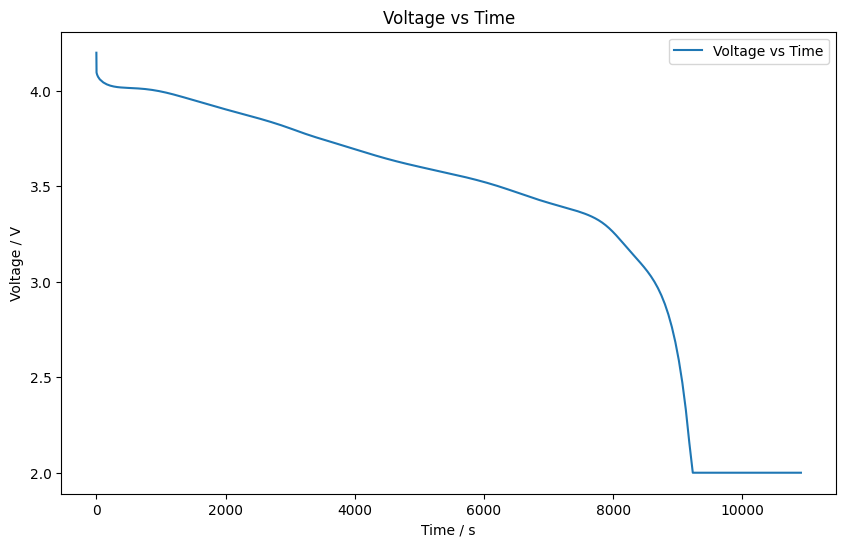

In [69]:
# Extract column names for 'Time' and 'CellVoltage' based on propertyUrl
time_column = None
voltage_column = None

# Get the relevant IRIs from the context
context_url = 'https://raw.githubusercontent.com/emmo-repo/domain-battery/master/context.json'
response = requests.get(context_url)
context_data = response.json()

time_iri = context_data.get('@context', {}).get('Time')
voltage_iri = context_data.get('@context', {}).get('CellVoltage')

# Get the time column label
query = f"""
PREFIX csvw: <http://www.w3.org/ns/csvw#>

SELECT ?columnName WHERE {{
    ?table csvw:tableSchema ?schema.
    ?schema csvw:columns ?column.

    ?column csvw:propertyUrl ?propertynode.
    ?propertynode a <{time_iri}>.
    ?column csvw:titles ?columnName.
}}
"""

# Execute the SPARQL query
results = g.query(query)

# Print the results
for row in results:
    time_column = str(row[0])  # Convert the Literal to a string

# Get the voltage column label
query = f"""
PREFIX csvw: <http://www.w3.org/ns/csvw#>

SELECT ?columnName WHERE {{
    ?table csvw:tableSchema ?schema.
    ?schema csvw:columns ?column.

    ?column csvw:propertyUrl ?propertynode.
    ?propertynode a <{voltage_iri}>.
    ?column csvw:titles ?columnName.
}}
"""

# Execute the SPARQL query
results = g.query(query)

# Print the results
for row in results:
    voltage_column = str(row[0])  # Convert the Literal to a string

# Check if columns are found
if time_column and voltage_column:
    # Plot Voltage vs Time
    plt.figure(figsize=(10, 6))
    plt.plot(df[time_column], df[voltage_column], label="Voltage vs Time")
    plt.xlabel(f"{time_column}")
    plt.ylabel(f"{voltage_column}")
    plt.title("Voltage vs Time")
    plt.legend()
    plt.show()
else:
    print("Required columns not found in metadata.")
